In [1]:
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim


# In order to make the import of local modules
import sys
sys.path.append('.')

# local modules
from ultimate_tic_tac_toe_2 import *

In [28]:
# TODO - you need a more complex model to represent the interactions between the cells: more channels typically

'''
class ValueFunction(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, padding=0, stride=3, bias=False),
            nn.ReLU(),
            nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, padding=0, stride=1, bias=False),
        )

    def forward(self, board_matrix: torch.Tensor) -> torch.Tensor:
        xs = torch.FloatTensor(board_matrix)
        if len(xs.shape) == 2:
            xs = xs.unsqueeze(dim=0)
        batch_size, h, w = xs.shape
        xs = xs.reshape((batch_size, 1, h, w))
        xs = self.fc(xs)
        xs = xs.reshape((batch_size,))
        return xs
'''


class ValueFunction(nn.Module):
    def __init__(self):
        super().__init__()
        '''
        self.fc = nn.Sequential(
            nn.Linear(9*9, 50),
            nn.ReLU(),
            nn.Linear(50, 1))
        '''
        self.fc = nn.Linear(9*9, 1, bias=False)

    def forward(self, board_matrix: torch.Tensor) -> torch.Tensor:
        xs = torch.FloatTensor(board_matrix)
        if len(xs.shape) == 2:
            xs = xs.unsqueeze(dim=0)
        batch_size, h, w = xs.shape
        xs = xs.reshape((batch_size, h * w))
        xs = self.fc(xs)
        xs = xs.reshape((batch_size,))
        return xs
    

policy = ValueFunction()
print(policy(np.ones(shape=(9, 9))))
print(policy(np.ones(shape=(5, 9, 9))))

tensor([0.3445], grad_fn=<AsStridedBackward>)
tensor([0.3445, 0.3445, 0.3445, 0.3445, 0.3445], grad_fn=<AsStridedBackward>)


100%|██████████| 250/250 [00:28<00:00,  7.80it/s]


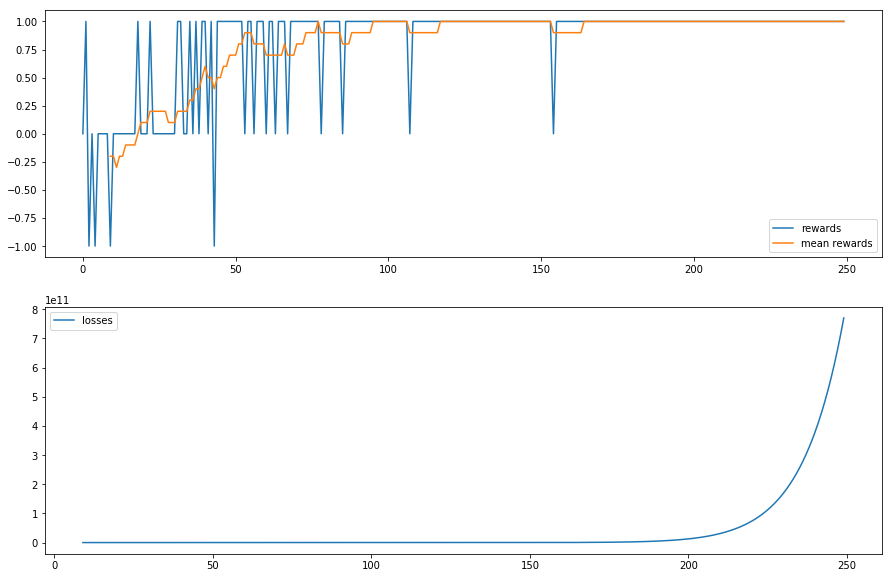

In [38]:
"""
Trying to learn a matrix of weight in order to score a board
"""

def train(policy: nn.Module, adversary_agent, episodes: int,
          start_epsilon: float, min_epsilon: float,
          learning_rate: float, learning_rate_decay: float,
          weight_decay: float
         ):
    
    rewards = []
    losses = []
    epsilon = start_epsilon

    criterion = nn.MSELoss()
    optimizer = optim.SGD(policy.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=learning_rate_decay)

    for episode in trange(episodes):
        episode_loss = 0
        episode_reward = 0

        board = Board.empty()
        player_id = random.choice([PLAYER, OPPONENT])

        while not board.is_game_over():
            # Play the opponent turn
            if player_id == OPPONENT:
                move = adversary_agent.get_action(board)
                board = board.play(OPPONENT, move)
                player_id = next_player(player_id)
                continue

            # Choose epsilon-greedy action
            if np.random.rand(1) < epsilon:
                move = random.choice(board.available_moves)
                next_board = board.play(player_id, move)
            else:
                # policy.eval()
                boards = [board.play(player_id, move) for move in board.available_moves]
                # TODO - why does it fail when I stack the matrices?
                '''
                ms = np.stack([b.as_board_matrix() for b in boards])
                vs = policy(ms)
                # print(vs)
                v, i = torch.max(vs, -1)
                # print(i)
                next_board = boards[i.item()]
                '''
                # '''
                boards.sort(key=lambda b: policy(b.as_board_matrix()).item(), reverse=True if player_id == PLAYER else False)
                next_board = boards[0]
                # '''
            
            # Receive next state and reward
            if next_board.winner == PLAYER:
                reward = 1.
                epsilon = max(min_epsilon, epsilon * 0.95)
                scheduler.step()
            elif next_board.winner == OPPONENT:
                reward = -1.
            else:
                reward = 0.

            # Find V for t and t+1 state
            # policy.train()
            V = policy(board.as_board_matrix())
            V_target = policy(next_board.as_board_matrix()).detach() + reward
            # V_target = policy(next_board.as_board_matrix()) + reward

            # Calculate loss & Update policy
            policy.zero_grad()
            loss = criterion(V, V_target)
            loss.backward()
            optimizer.step()

            # Record history
            episode_reward += reward
            episode_loss += loss.item()

            # Step forward
            board = next_board
            player_id = next_player(player_id)

        # print(board)
        rewards.append(episode_reward)
        losses.append(episode_loss)

    # Reporting
    fig, ax = plt.subplots(figsize=(15, 10), nrows=2)
    ax[0].plot(rewards, label="rewards")
    ax[0].plot(pd.Series(rewards).rolling(10).mean(), label="mean rewards")
    ax[1].plot(pd.Series(losses).rolling(10).sum() / 100., label="losses")
    for p in ax:
        p.legend()
    plt.show()

    
torch.manual_seed(1);
np.random.seed(1)

policy = ValueFunction()
train(policy=policy,
      adversary_agent=FirstMoveAgent(),
      episodes=250,
      start_epsilon=0.5, min_epsilon=0.0,
      learning_rate=1e-2, learning_rate_decay=1.0,
      weight_decay=0.)

In [39]:
print(policy)
for param in policy.parameters():
    print(param.data)

ValueFunction(
  (fc): Linear(in_features=81, out_features=1, bias=False)
)
tensor([[-8.8800e+01,  5.0758e+04,  5.9354e+01, -1.3219e+05, -8.0178e-02,
          1.6544e+03, -1.8166e+03,  5.5714e+01,  3.7431e+00,  8.2601e+04,
         -1.1392e+06,  2.0837e+05,  1.2419e+00, -2.5081e+06,  4.4152e+00,
          8.1870e+02, -1.6977e+06,  1.5640e+02,  7.5720e+05,  4.9825e+05,
          1.8111e+04, -5.0598e+04,  6.0771e+00, -3.7821e+01, -3.3284e+02,
          1.6716e+00,  1.0417e+04, -8.2609e+04,  3.6311e-02, -1.3417e+01,
          1.1392e+06,  2.5081e+06,  1.6977e+06, -3.2082e+03,  6.6816e+00,
         -7.8276e-01,  3.6459e+00, -3.2413e+05,  3.1384e-01,  3.4707e+00,
         -1.8369e+06,  1.2909e+02,  1.9922e-01, -2.0847e+05,  6.4547e-02,
         -8.1536e+02,  4.4803e-01,  4.7304e-01,  2.2039e+02,  1.1350e+01,
          3.1585e+01, -1.4585e+02,  2.9993e+00,  2.4200e-02, -1.1706e+02,
          1.3215e+05,  3.7177e+02, -3.0620e+04,  8.1685e+00, -3.5954e-01,
         -1.0404e+04,  1.0533e-01, -

100%|██████████| 250/250 [00:15<00:00, 15.97it/s]


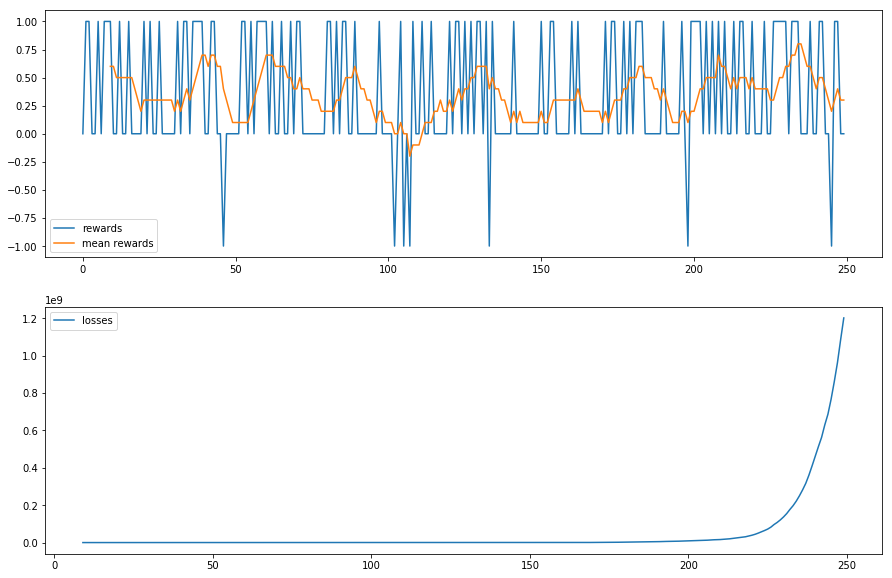

In [40]:
# adversary_agent = MinimaxAgent(player=OPPONENT, max_depth=2, eval_fct=CountOwnedEvaluation())
policy = ValueFunction()
train(policy=policy,
      adversary_agent=RandomAgent(),
      episodes=250,
      start_epsilon=0.5, min_epsilon=0.0,
      learning_rate=1e-2, learning_rate_decay=1.0,
      weight_decay=0.)

In [33]:
print(policy)
for param in policy.parameters():
    print(param.data)

ValueFunction(
  (fc): Linear(in_features=81, out_features=1, bias=False)
)
tensor([[ -47077.7695,  194137.4062,  -81232.1953,  -38727.0000,  -72660.8906,
          -31673.0820,   80585.3438,  -17000.3613,  -66550.6250,  -90320.6094,
           42847.6562, -123101.3438,   12431.1367,  100620.7344,  -30613.6367,
          216896.2500,  -31571.5566,  459001.4375, -105296.3281,  -49029.9141,
         -144947.1094,  -58296.5000,  -34918.0430,  282880.1875,  -33174.7500,
          -17435.6914,    2283.8054,  -77554.2500,  -34850.6172,  -58660.5898,
         -170957.9844, -155841.1250, -132925.2031,   70104.6875,  -52453.6055,
         -111011.6172,  196268.4844,  -14494.0518,  -58438.2617,  -81865.7422,
          221813.5312,  -69885.8047,  -63837.4336,  -66446.1875,  -99486.9141,
          -53175.3984,  -69814.4766,   -5771.1714,  -27359.0391,  -42722.1133,
         -144934.2812,  -18957.3184,  224358.1094,  -52444.0547,  250272.0938,
          -23626.1484,  -11876.7949,  203126.1719,  -21